<a href="https://colab.research.google.com/github/Diogoa83/Inteligencia-de-Mercado/blob/main/Convenio_Governo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mplcyberpunk
!pip install python-bcb

In [24]:
import mplcyberpunk
import seaborn as sns
import pandas as pd
from bcb import sgs
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from matplotlib.dates import date2num
from datetime import datetime
from datetime import timedelta
plt.style.use("cyberpunk")

In [23]:
import numpy as np
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
import pandas.util.testing as tm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

In [60]:
df_governo = pd.read_csv('/content/drive/MyDrive/Dados/convenio_GOVERNOS.csv', sep=';')
df_governo['Data'] = pd.to_datetime(df_governo['Data'], format='%d/%m/%Y')

In [61]:
df_governo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Data                    31 non-null     datetime64[ns]
 1   ValorBase               31 non-null     object        
 2   Selic                   31 non-null     object        
 3   taxa_mensal_consignado  31 non-null     object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.1+ KB


In [62]:
# Remover vírgula e converter coluna para float
df_governo['ValorBase'] = df_governo['ValorBase'].str.replace(',', '.').astype(float)
df_governo['Selic'] = df_governo['Selic'].str.replace(',', '.').astype(float)
df_governo['taxa_mensal_consignado'] = df_governo['taxa_mensal_consignado'].str.replace(',', '.').astype(float)

In [63]:
df_governo.head(4)

,Data,ValorBase,Selic,taxa_mensal_consignado
0,2020-12-01,501693.0,2.0,1.24
1,2021-01-01,1137781.0,2.0,1.26
2,2021-02-01,1467057.0,2.0,1.26
3,2021-03-01,2228465.0,2.0,1.27


In [64]:
df_governo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Data                    31 non-null     datetime64[ns]
 1   ValorBase               31 non-null     float64       
 2   Selic                   31 non-null     float64       
 3   taxa_mensal_consignado  31 non-null     float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.1 KB


In [65]:
df_governo.corr()

<ipython-input-65-23167bce90f7>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_governo.corr()


,ValorBase,Selic,taxa_mensal_consignado
ValorBase,1.000000,0.614297,0.554833
Selic,0.614297,1.000000,0.969828
taxa_mensal_consignado,0.554833,0.969828,1.000000


# MODELO ARIMA GOVERNO TREINO/TESTE

In [66]:
train_size = int(len(df_governo.ValorBase) * 2 / 3)
train_size

20

In [67]:
train_set = df_governo.ValorBase[:train_size]
test_set = df_governo.ValorBase[train_size:]

In [68]:
train_set.shape, test_set.shape

((20,), (11,))

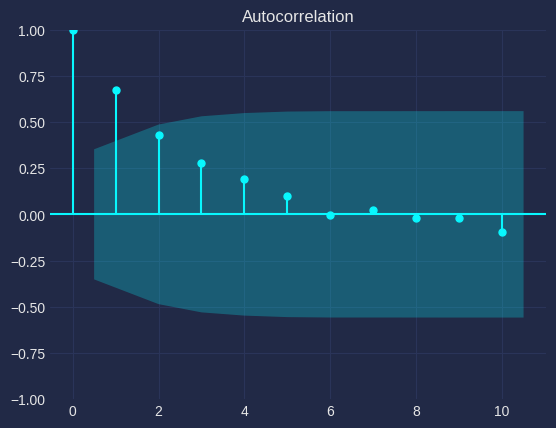

In [69]:
plot_acf(df_governo.ValorBase, lags=10)
pyplot.show()

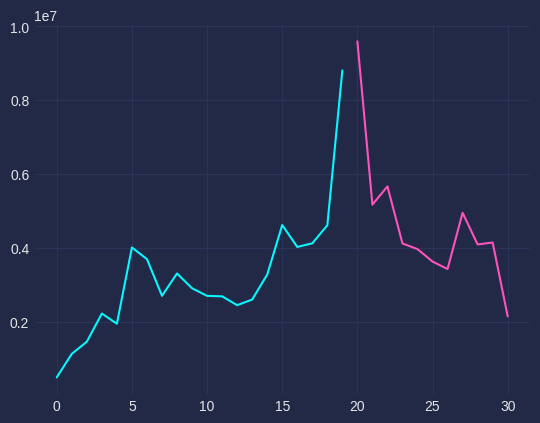

In [70]:
plt.plot(train_set)
plt.plot(test_set)

In [71]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import AutoReg

ar_2 = AutoReg(train_set, lags=2).fit()
ar_2.params

const           159807.917403
ValorBase.L1         0.960475
ValorBase.L2         0.137801
dtype: float64

In [72]:
previsoes = ar_2.params[0] + test_set.shift(1) * ar_2.params[1] + test_set.shift(2) * ar_2.params[2]

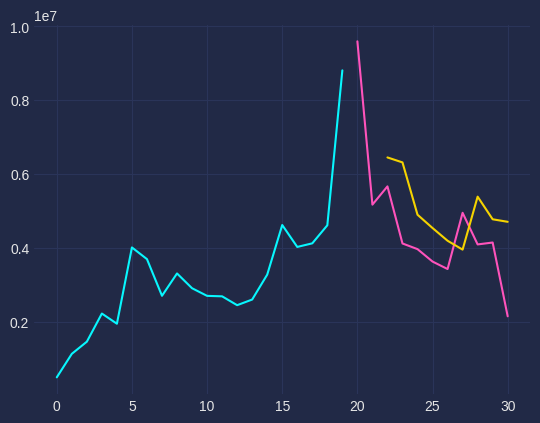

In [27]:
plt.plot(train_set)
plt.plot(test_set)
plt.plot(previsoes)

In [29]:
((test_set - previsoes) ** 2).mean()

1923844078735.033

# PREVISÕES SARIMAX CONVENIO FEDERAL

In [73]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [74]:
# Converter coluna de datas para o tipo datetime
df_governo['Data'] = pd.to_datetime(df_governo['Data'])

# Definir a coluna 'Data' como o índice do DataFrame
df_governo.set_index('Data', inplace=True)

# Verificar o índice atualizado


In [75]:
df_governo.head(5)

,ValorBase,Selic,taxa_mensal_consignado
Data,,,
2020-12-01,501693.0,2.00,1.24
2021-01-01,1137781.0,2.00,1.26
2021-02-01,1467057.0,2.00,1.26
2021-03-01,2228465.0,2.00,1.27
2021-04-01,1953491.0,2.75,1.30


In [80]:
sarima = SARIMAX(df_governo.ValorBase, freq='MS', order=(2, 1, 2), seasonal_order=(2, 1, 1, 12)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [82]:
print((sarima.resid ** 2).mean())

1650010690949.3645


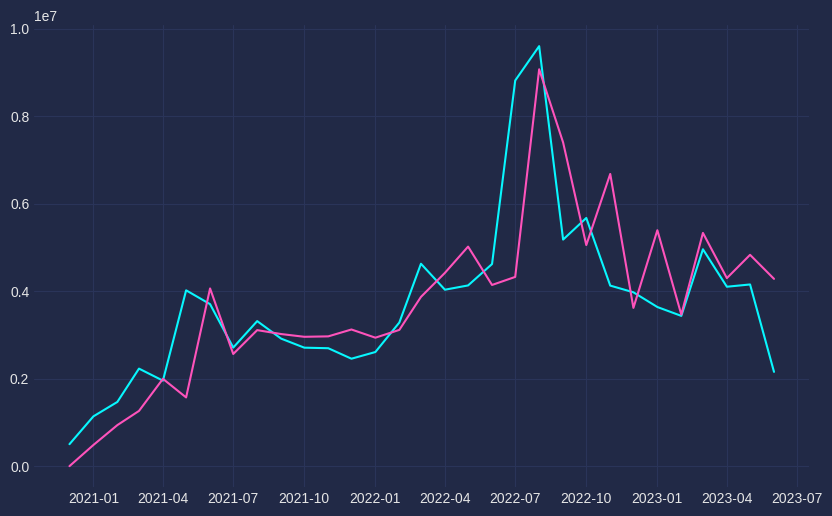

In [83]:
plt.figure(figsize=(10, 6))
plt.plot(df_governo.ValorBase)
plt.plot(sarima.predict(typ='levels'))

# PREVISÕES COM ARIMA CONVENIO FEDERAL

In [53]:
from statsmodels.tsa.arima.model import ARIMA


In [54]:
arima = ARIMA(df_governo['ValorBase'], order=(3, 1, 1))
arima_fit = arima.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [55]:
# Calcular o quadrado dos resíduos médios
mse = (arima_fit.resid ** 2).mean()
print(mse)

1767498155876.4087


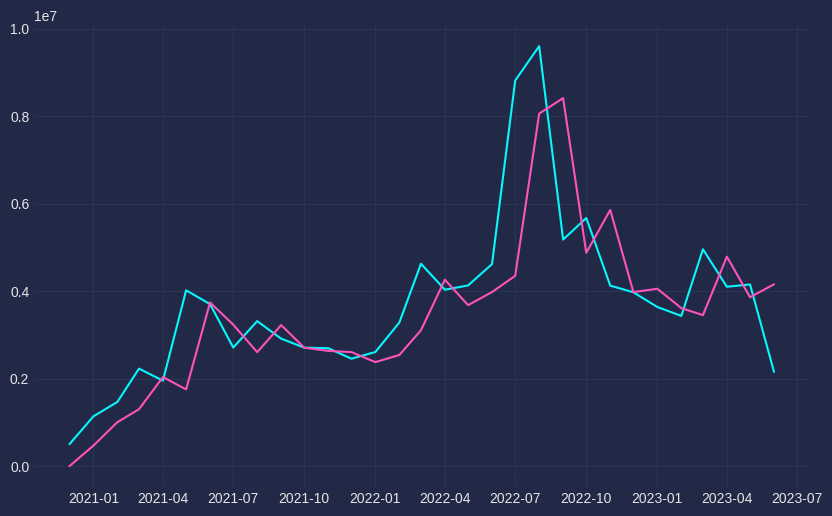

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_governo.ValorBase)
plt.plot(arima_fit.predict(typ='levels'))